### Imports

In [1]:
import pyedflib
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy import signal
from imp import reload

<module 'matplotlib.pyplot' from 'C:\\Users\\Ricardo\\anaconda3\\envs\\ENAC_EOG_Detection\\lib\\site-packages\\matplotlib\\pyplot.py'>

### Reading Data

The data is read from an edf file, the EOG channels are extracted and the file is closed.

The edf file contains 272 channels, from all those channels, we are only interested in 4 of them:


| Channel Number | Channel Name | EOG Electrode |
| :---: | :------: | :------------------: |
| 256 | EXG1 | Left Electrode |
| 257 | EXG2 | Right Electrode |
| 258 | EXG3 | Up Electrode |
| 259 | EXG4 | Down Electrode |

In [2]:
# Reading the signals from the EDF file

f = pyedflib.EdfReader('C:/Users/Ricardo\source/enac-eog-analysis/data/EOG_EyeLink/RI02/Testdata0602.edf')
numSignals = f.signals_in_file

# These are the numbers of the channels that interest us
channelsOfInterest = [256, 257, 258, 259]
numEyeChannels = len(channelsOfInterest)

# Frequency Sampling
freqSample = 2048

signal_labels = f.getSignalLabels()
#print(signal_labels)

# Creation of a zero array the correct dimensions.
eyesData = np.zeros((numEyeChannels, f.getNSamples()[0]))

for i, channel in enumerate(channelsOfInterest):
    eyesData[i, :] = f.readSignal(channel)

f.close()

### Pre Processing

This section of the code is for signal processing like **noise filtering** and **baseline drift/wandering removal**.

For **baseline drift mitigation**, we used:
1. Scipy Detrend Function
2. 10th order Butterworth high-pass filter with optimal cut-off frequency described in literature: 0.04Hz

**Note:** The high-pass is useful for real time applications.

**Note:** The signal needs to be checked for baseline drift, because if it doesn't have it, then it is **unnecessary** to apply baseline drift mitigation.

In [3]:
# Pre-processing of the signal using butterworth filter
type(eyesData)
sos = signal.butter(10, 10, 'lp', fs=2048, output='sos')
eyesDataFiltered = signal.sosfilt(sos, eyesData)

In [4]:
# Pre-processing: baseline wandering/drift mitigation
eyesDataFiltered2 = signal.detrend(eyesDataFiltered)

In [5]:
# Pre-processing: baseline wandering/drift mitigation
sos2 = signal.butter(1, 0.04, 'highpass', fs=2048, output='sos')
eyesDataFiltered3 = signal.sosfilt(sos2, eyesDataFiltered)

### Ploting Example

Part of the signal that corresponds to calibration.

In [6]:
def plotEogSignal(signal, start=0, end=1000, labels=[],
                  xAxisLabel='Amplitude (microVolts)',
                  yAxisLabel='Datapoint'):   
    plt.figure(figsize=(20, 5))
    signal = signal[:, start:end]
    signal = np.swapaxes(signal,0,1) 
    plt.plot(signal)
    plt.xlabel(xAxisLabel)
    plt.ylabel(yAxisLabel)
    plt.legend(labels)    
    plt.show()

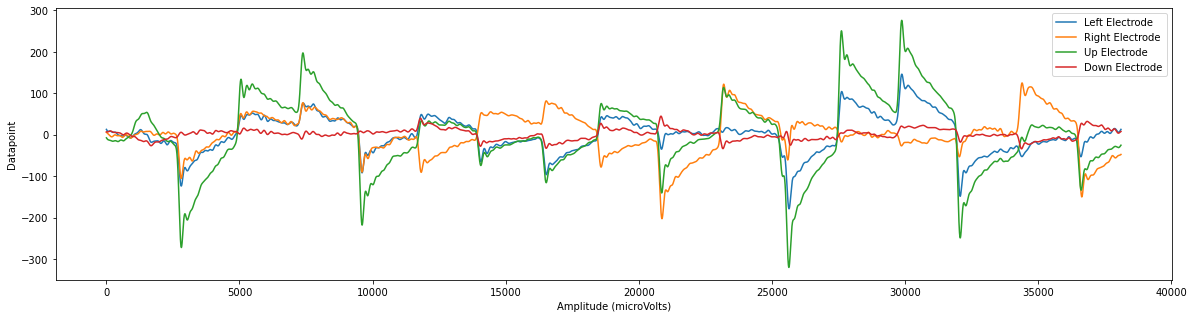

In [8]:
calibrationStart = 116396
calibrationEnd = 154517
labels = ['Left Electrode', 'Right Electrode', 'Up Electrode', 'Down Electrode']
plotEogSignal(eyesDataFiltered3, start=calibrationStart, end=calibrationEnd, labels=labels)

# Subtracting the signals

To analyze the signal, we must subtract the potencials from the Up and Down Electrode and the Left and Right Electrode.

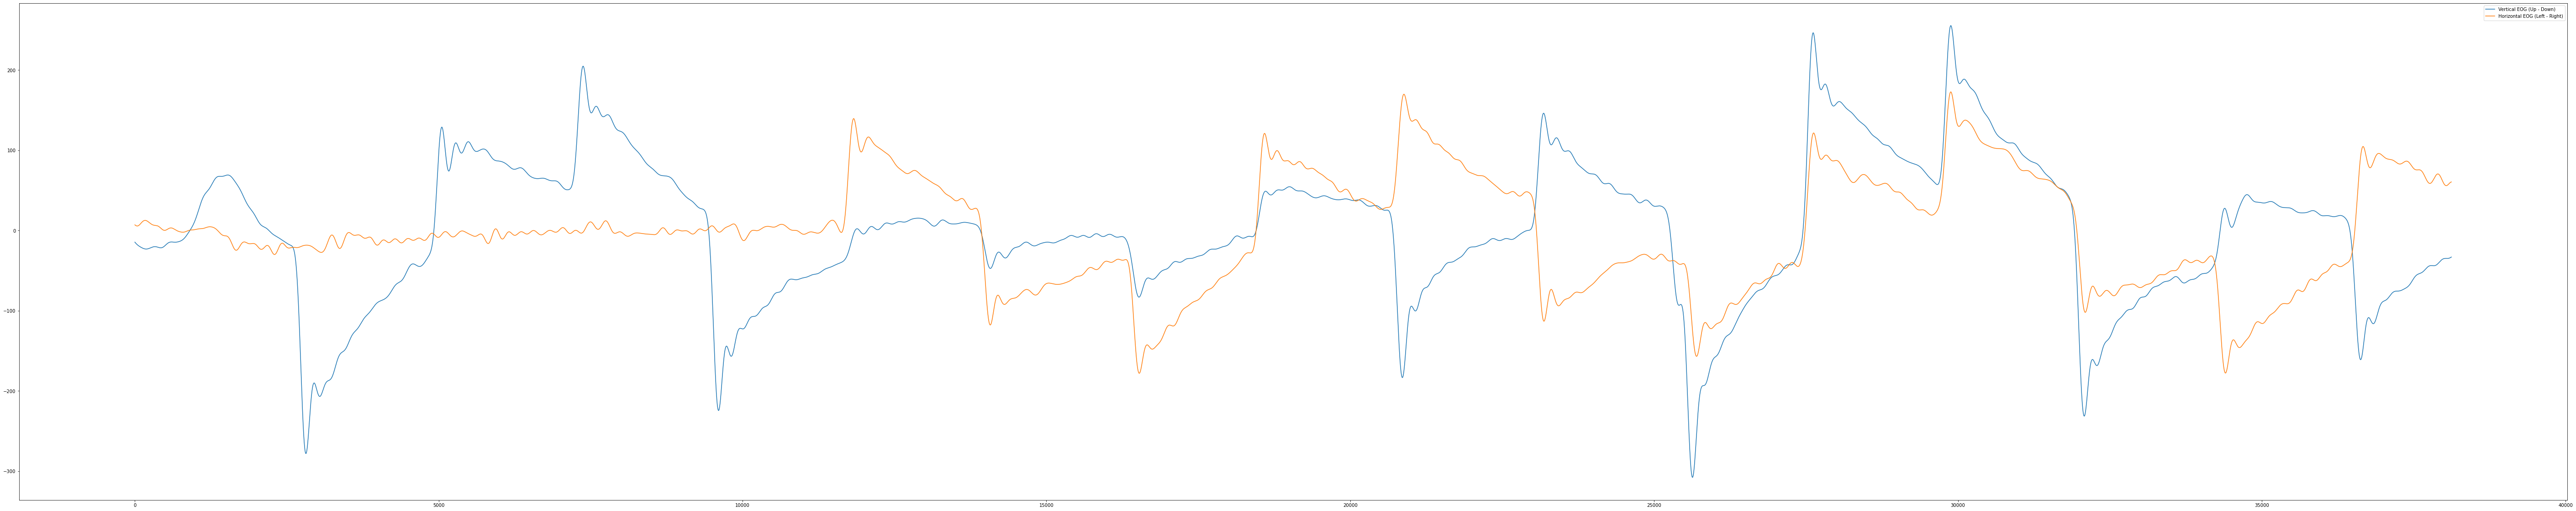

In [18]:
# Subtraction of the signals
leftElec = eyesDataFiltered3[0]
rightElec = eyesDataFiltered3[1]
upElec = eyesDataFiltered3[2]
downElec = eyesDataFiltered3[3]

verticalEOG = np.subtract(upElec, downElec)
horizontalEOG = np.subtract(leftElec, rightElec)

sampleVert = verticalEOG[calibrationStart : calibrationEnd]
sampleHor = horizontalEOG[calibrationStart : calibrationEnd]

plt.figure( figsize=( 100, 20 ) )

plt.plot(sampleVert)
plt.plot(sampleHor)
labels = ['Vertical EOG (Up - Down)', 'Horizontal EOG (Left - Right)']
plt.legend(labels)
plt.show()



# Saccade Detection

This section is dedicated to using several algorithms for saccada detection:
1. Continuous Wavelet Transform
2. other methods...